# Importing Necessary Libraries

- **Numpy** is used for numerical operations.
- **Pandas** is used for data manipulation and analysis.
- **Matplotlib** is used for plotting and data visualization.
- **Scipy's stats module** is used for statistical functions, including the Poisson distribution.
- **Sklearn's metrics module** is used for evaluating machine learning models.


In [63]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from scipy.stats import poisson
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, roc_auc_score

import warnings
warnings.filterwarnings('ignore')

# Reading and Cleaning Data

To begin our analysis, we collected historical match data. Dataset that we use contains the outcomes of international football matches from the very first official match in 1872 through to 2024.

In [4]:
data = pd.read_csv('datasets/results.csv',sep=',',)
data=data[~data['home_score'].isna()]

# Understanding the Elo Ranking Dynamics

The Elo ranking system serves as a dynamic tool for assessing teams' relative skill levels based on their match performances. This system evaluates teams by adjusting their ratings after each match, taking into account wins, losses, and the strength of their opponents.

To construct our dataset, we must establish various parameters, including the weighting of each tournament in influencing the Elo rankings' adjustments.

In [8]:
# List of continental tournaments and qualifiers
continental_tournaments = ['AFC Asian Cup', 'African Cup of Nations', 'UEFA Euro', 'Copa América', 'CONCACAF Championship', 'Oceania Nations Cup']
continental_qualifiers = ['UEFA Euro qualification', 'African Cup of Nations qualification', 'AFC Asian Cup qualification', 'UEFA Nations League']

In [9]:
# Determines the K-factor based on the tournament type 
def determine_k_factor(tournament):
    k = 5
    if tournament == 'Friendly':
        k = 10
    elif tournament in continental_qualifiers:
        k = 20
    elif tournament == 'FIFA World Cup qualification':
        k = 25
    elif tournament in continental_tournaments:
        k = 40
    elif tournament == 'FIFA World Cup':
        k = 50
    return k

In [11]:
# Calculates the expected outcome of a match based on Elo ratings
def calculate_expected_result(home_rating, away_rating):
    rating_difference = home_rating - away_rating
    expected_home_win = 1 / (10 ** (-rating_difference / 400) + 1)
    return [round(expected_home_win, 3), 1 - round(expected_home_win, 3)]

# Determines the actual outcome of a match based on goals scored
def determine_actual_result(home_goals, away_goals):
    if home_goals > away_goals:
        return [1, 0]
    elif home_goals < away_goals:
        return [0, 1]
    else:
        return [0.5, 0.5]

# Computes updated Elo ratings after a match
def compute_elo_ratings(home_elo, away_elo, home_goals, away_goals, tournament):
    k = determine_k_factor(tournament)
    actual_home, actual_away = determine_actual_result(home_goals, away_goals)
    expected_home, expected_away = calculate_expected_result(home_elo, away_elo)

    updated_home_elo = home_elo + k * (actual_home - expected_home)
    updated_away_elo = away_elo + k * (actual_away - expected_away)

    return updated_home_elo, updated_away_elo, expected_home, expected_away


In [12]:
# Initialize dictionary to store current Elo ratings for each team
current_elo_ratings = {}

# Loop through each match in the dataset 'data'
for index, match in data.iterrows():
    home_team = match['home_team']
    away_team = match['away_team']
    home_goals = match['home_score']
    away_goals = match['away_score']
    tournament_type = match['tournament']

    # Initialize Elo rating for each team if not already in dictionary
    if home_team not in current_elo_ratings:
        current_elo_ratings[home_team] = 1300
    if away_team not in current_elo_ratings:
        current_elo_ratings[away_team] = 1300

    # Retrieve current Elo ratings for home and away teams
    home_elo = current_elo_ratings[home_team]
    away_elo = current_elo_ratings[away_team]

    # Compute updated Elo ratings after the match
    updated_home_elo, updated_away_elo, prob_home_win, prob_away_win = compute_elo_ratings(home_elo, away_elo, home_goals, away_goals, tournament_type)

    # Update Elo ratings in the dictionary for future matches
    current_elo_ratings[home_team] = updated_home_elo
    current_elo_ratings[away_team] = updated_away_elo

    # Update DataFrame 'data' with Elo ratings and probabilities
    data.loc[index, 'Elo_h_after'] = updated_home_elo
    data.loc[index, 'Elo_a_after'] = updated_away_elo
    data.loc[index, 'Elo_h_before'] = home_elo
    data.loc[index, 'Elo_a_before'] = away_elo
    data.loc[index, 'probH'] = prob_home_win
    data.loc[index, 'probA'] = prob_away_win

In [13]:
# Combine Elo ratings for home and away teams into a single DataFrame
elo_ratings = pd.concat([
    data[['date', 'home_team', 'Elo_h_after']].rename(columns={'home_team': 'Team', 'Elo_h_after': 'Elo'}),
    data[['date', 'away_team', 'Elo_a_after']].rename(columns={'away_team': 'Team', 'Elo_a_after': 'Elo'})
])

# Sort Elo ratings by date and keep only the latest rating for each team
elo_ratings.sort_values(by='date', ascending=False, inplace=True)
elo_ratings.drop_duplicates('Team', inplace=True)

# Sort teams by Elo rating in descending order and reset index
elo_ratings.sort_values(by='Elo', ascending=False, inplace=True)
elo_ratings.reset_index(drop=True, inplace=True)
elo_ratings['Rank'] = elo_ratings.index + 1  # Add rank column

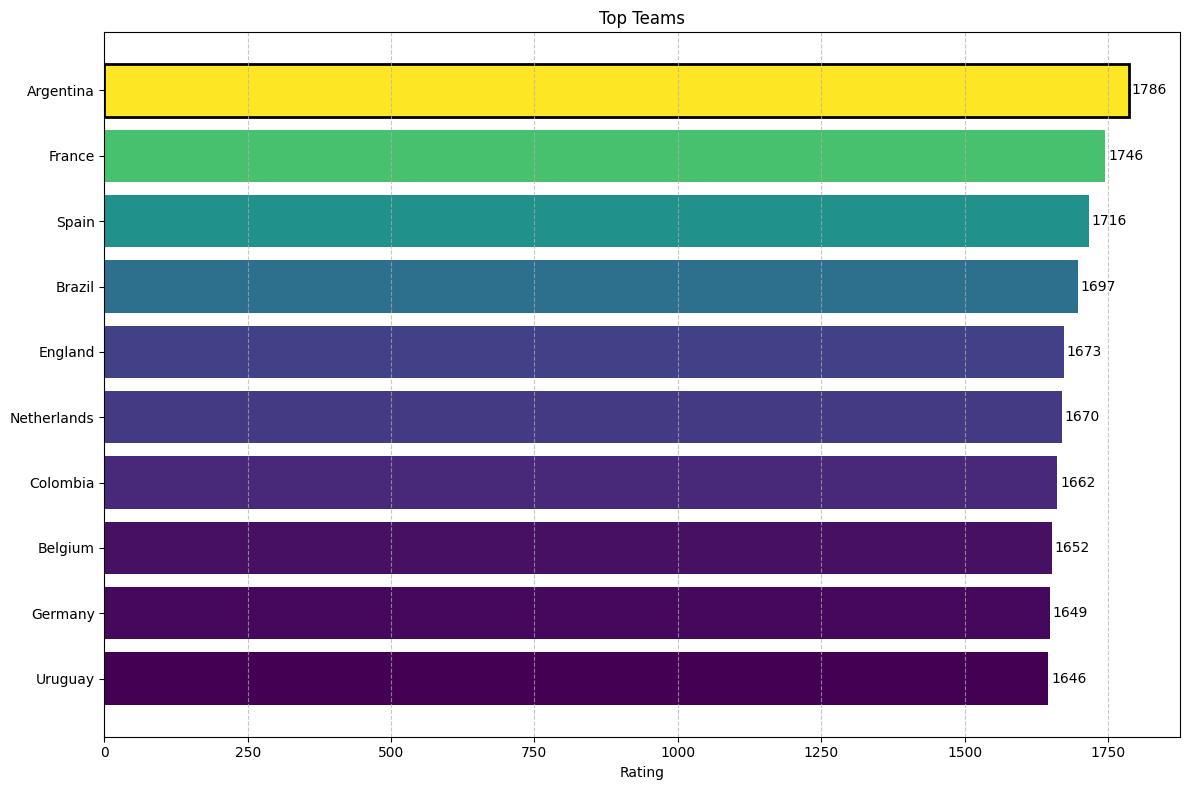

In [16]:
# Plots the top n teams by Elo rating in bar chart
def plot_top_teams(elos, n=10):
    # Sort DataFrame by Elo rating in descending order
    elos.sort_values(by='Elo', ascending=False, inplace=True)

    # Select top n teams
    top_teams = elos.head(n)

    # Define color map and normalize Elo ratings for color gradient
    cmap = plt.get_cmap('viridis')
    norm = mcolors.Normalize(vmin=min(top_teams['Elo']), vmax=max(top_teams['Elo']))
    colors = cmap(norm(top_teams['Elo']))

    # Create horizontal bar chart
    plt.figure(figsize=(12, 8))
    bars = plt.barh(top_teams['Team'], top_teams['Elo'], color=colors)
    
    # Add Elo rating annotations
    for bar in bars:
        plt.text(
            bar.get_width() + 5, 
            bar.get_y() + bar.get_height() / 2, 
            f'{bar.get_width():.0f}', 
            ha='left', 
            va='center',
            fontsize=10
        )

    # Highlight the top-ranked team
    bars[0].set_edgecolor('black')
    bars[0].set_linewidth(2)

    # Customize plot labels and appearance
    plt.xlabel('Rating')
    plt.title('Top Teams')
    plt.gca().invert_yaxis()  # Invert y-axis to show highest Elo at the top
    plt.grid(axis='x', linestyle='--', alpha=0.7)

    # Display plot
    plt.tight_layout()
    plt.show()

# Visualize top 10 teams overall
plot_top_teams(elo_ratings, 10)

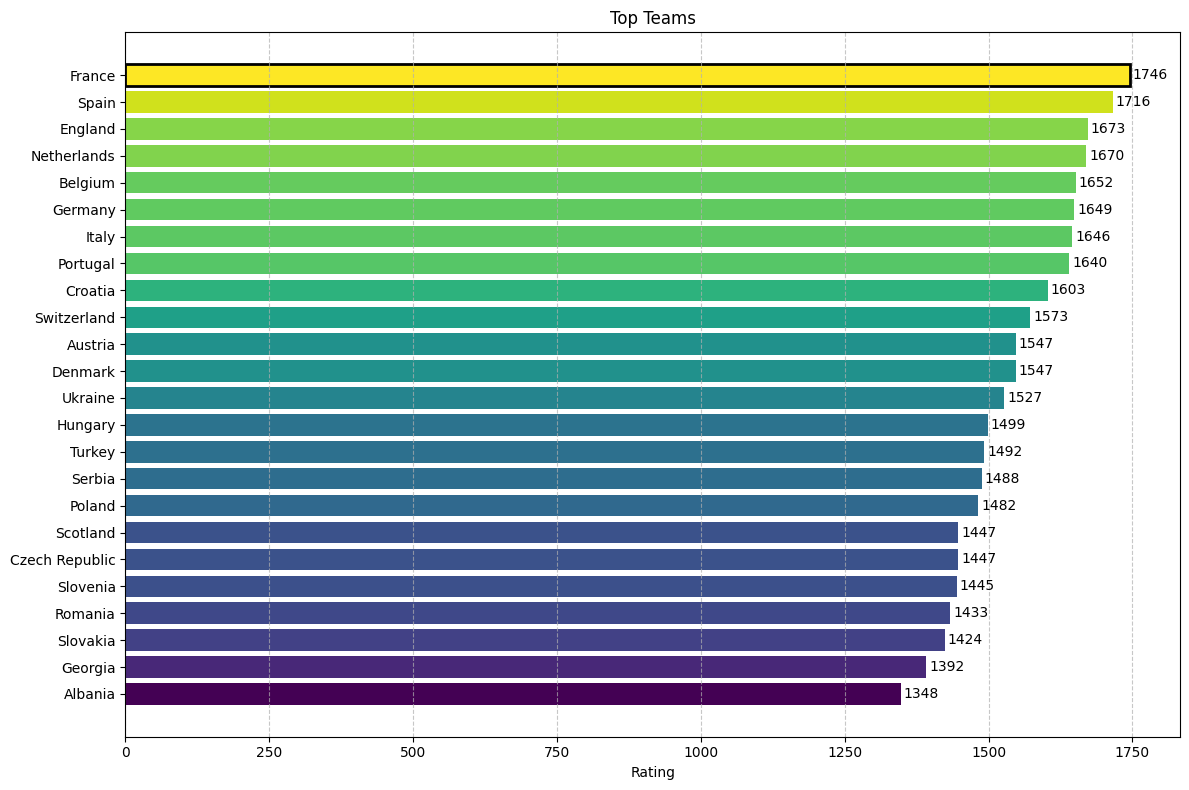

In [17]:
# Filter teams participating in Euro 2024 and visualize their Elo ratings
eurocup_teams = [
    "Albania", "Scotland", "Hungary", "Romania",
    "Germany", "Slovakia", "England", "Czech Republic",
    "Austria", "Slovenia", "Italy", "Serbia",
    "Belgium", "Spain", "Netherlands", "Switzerland",
    "Croatia", "France", "Poland", "Turkey",
    "Denmark", "Georgia", "Portugal", "Ukraine"
]

euro_teams_elo = elo_ratings[elo_ratings['Team'].isin(eurocup_teams)].copy()
plot_top_teams(euro_teams_elo, 24)  # Visualize top 24 teams participating in Euro 2024

# Understanding Team Performance Metrics

In addition to Elo ratings, we can enhance our analysis by introducing metrics for attacking and defensive capabilities. This approach helps in evaluating teams beyond match outcomes, considering their offensive and defensive strengths relative to opponents.

In [18]:
# Calculate updated attacking and defensive ratings after a match
def calculate_attdef(Attack_l, Attack_v, Deffend_l, Deffend_v, localGoals, awayGoals, tournament, neutral):
    k = determine_k_factor(tournament)  # Calculate the k-value based on the tournament type
    if not neutral:
        c = 1.27  # Home advantage factor
    else:
        c = 1

    # Calculate expected goals based on current ratings
    expected_home_goals = Attack_l * Deffend_v * c
    expected_away_goals = Attack_v * Deffend_l / c

    # Update ratings based on match outcome
    Attack_ln = Attack_l + (k / 2000) * (localGoals - expected_home_goals)
    Attack_vn = Attack_v + (k / 2000) * (awayGoals - expected_away_goals)
    Deffend_ln = Deffend_l + (k / 2000) * (awayGoals - expected_away_goals)
    Deffend_vn = Deffend_v + (k / 2000) * (localGoals - expected_home_goals)

    return Attack_ln, Attack_vn, Deffend_ln, Deffend_vn, expected_home_goals, expected_away_goals

Updating Team Ratings and DataFrame

In [19]:
# Initialize dictionaries to store current attacking and defensive ratings
current_att = {}
current_def = {}

# Iterate through each match in the DataFrame 'data'
for idx, row in data.iterrows():
    local = row['home_team']
    away = row['away_team']
    local_goals = row['home_score']
    away_goals = row['away_score']
    tournament = row['tournament']
    neutral = row['neutral']

    # Initialize ratings if the team is not in dictionaries
    if local not in current_att:
        current_att[local] = 1.3
    if away not in current_att:
        current_att[away] = 1.3
    if local not in current_def:
        current_def[local] = 1.3
    if away not in current_def:
        current_def[away] = 1.3

    # Retrieve current ratings
    att_l = current_att[local]
    att_v = current_att[away]
    def_l = current_def[local]
    def_v = current_def[away]

    # Calculate updated ratings and expected goals
    att_ln, att_vn, def_ln, def_vn, ehg, eag = calculate_attdef(att_l, att_v, def_l, def_v, local_goals, away_goals, tournament, neutral)

    # Update dictionaries with new ratings
    current_att[local] = att_ln
    current_att[away] = att_vn
    current_def[local] = def_ln
    current_def[away] = def_v

    # Update DataFrame 'data' with new ratings and expected goals
    data.loc[idx, 'att_h_after'] = att_ln
    data.loc[idx, 'att_a_after'] = att_vn
    data.loc[idx, 'att_h_before'] = att_l
    data.loc[idx, 'att_a_before'] = att_v
    data.loc[idx, 'def_h_after'] = def_ln
    data.loc[idx, 'def_a_after'] = def_vn
    data.loc[idx, 'def_h_before'] = def_l
    data.loc[idx, 'def_a_before'] = def_v
    data.loc[idx, 'XGhome'] = ehg
    data.loc[idx, 'XGaway'] = eag

Creating Team Ratings DataFrame

In [20]:
# Create a DataFrame 'attdef' containing updated attacking and defensive ratings
attdef = pd.concat([
    data[['date', 'home_team', 'att_h_after', 'def_h_after']].rename(columns={'home_team': 'Team', 'att_h_after': 'att', 'def_h_after': 'def'}),
    data[['date', 'away_team', 'att_a_after', 'def_a_after']].rename(columns={'away_team': 'Team', 'att_a_after': 'att', 'def_a_after': 'def'})
])
attdef.sort_values(by='date', ascending=False, inplace=True)
attdef.drop_duplicates('Team', inplace=True)
attdef.sort_values(by='def', ascending=True, inplace=True)
attdef.reset_index(drop=True, inplace=True)
attdef['def_position'] = attdef.index + 1
attdef.sort_values(by='att', ascending=False, inplace=True)
attdef.reset_index(drop=True, inplace=True)
attdef['att_position'] = attdef.index + 1

Plotting Top Teams by Attacking and Defensive Ratings

In [23]:
# Function to plot top teams by attacking and defensive ratings
def plot_top_att_def(elos, n=10):
    # Sort DataFrame by attacking and defensive ratings
    elos_sorted_att = elos.sort_values(by='att', ascending=False).head(n)
    elos_sorted_def = elos.sort_values(by='def', ascending=True).head(n)

    # Create color map for both plots
    colors_att = plt.cm.viridis(elos_sorted_att['att'] / max(elos_sorted_att['att']))
    colors_def = plt.cm.viridis(elos_sorted_def['def'] / max(elos_sorted_def['def']))

    # Create subplots for attacking and defensive ratings
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

    # Plot for attacking ratings
    bars_att = ax1.barh(elos_sorted_att['Team'], elos_sorted_att['att'], color=colors_att)
    ax1.set_title('Top Teams - Attacking Power', fontsize=16, weight='bold')
    ax1.invert_yaxis()  # Invert y-axis to display highest rating at the top
    ax1.grid(axis='x', linestyle='--', alpha=0.7)

    # Add text annotations for attacking ratings
    for bar in bars_att:
        ax1.text(
            bar.get_width() + 0.01, 
            bar.get_y() + bar.get_height() / 2, 
            f'{bar.get_width():.2f}', 
            ha='left', 
            va='center',
            fontsize=12,
            color='black'
        )

    # Plot for defensive ratings
    bars_def = ax2.barh(elos_sorted_def['Team'], elos_sorted_def['def'], color=colors_def)
    ax2.set_title('Top Teams - Defensive Power', fontsize=16, weight='bold')
    ax2.invert_yaxis()
    ax2.grid(axis='x', linestyle='--', alpha=0.7)

    # Add text annotations for defensive ratings
    for bar in bars_def:
        ax2.text(
            bar.get_width() + 0.01, 
            bar.get_y() + bar.get_height() / 2, 
            f'{bar.get_width():.2f}', 
            ha='left', 
            va='center',
            fontsize=12,
            color='black'
        )

    # Adjust layout and display plot
    plt.tight_layout()
    plt.show()

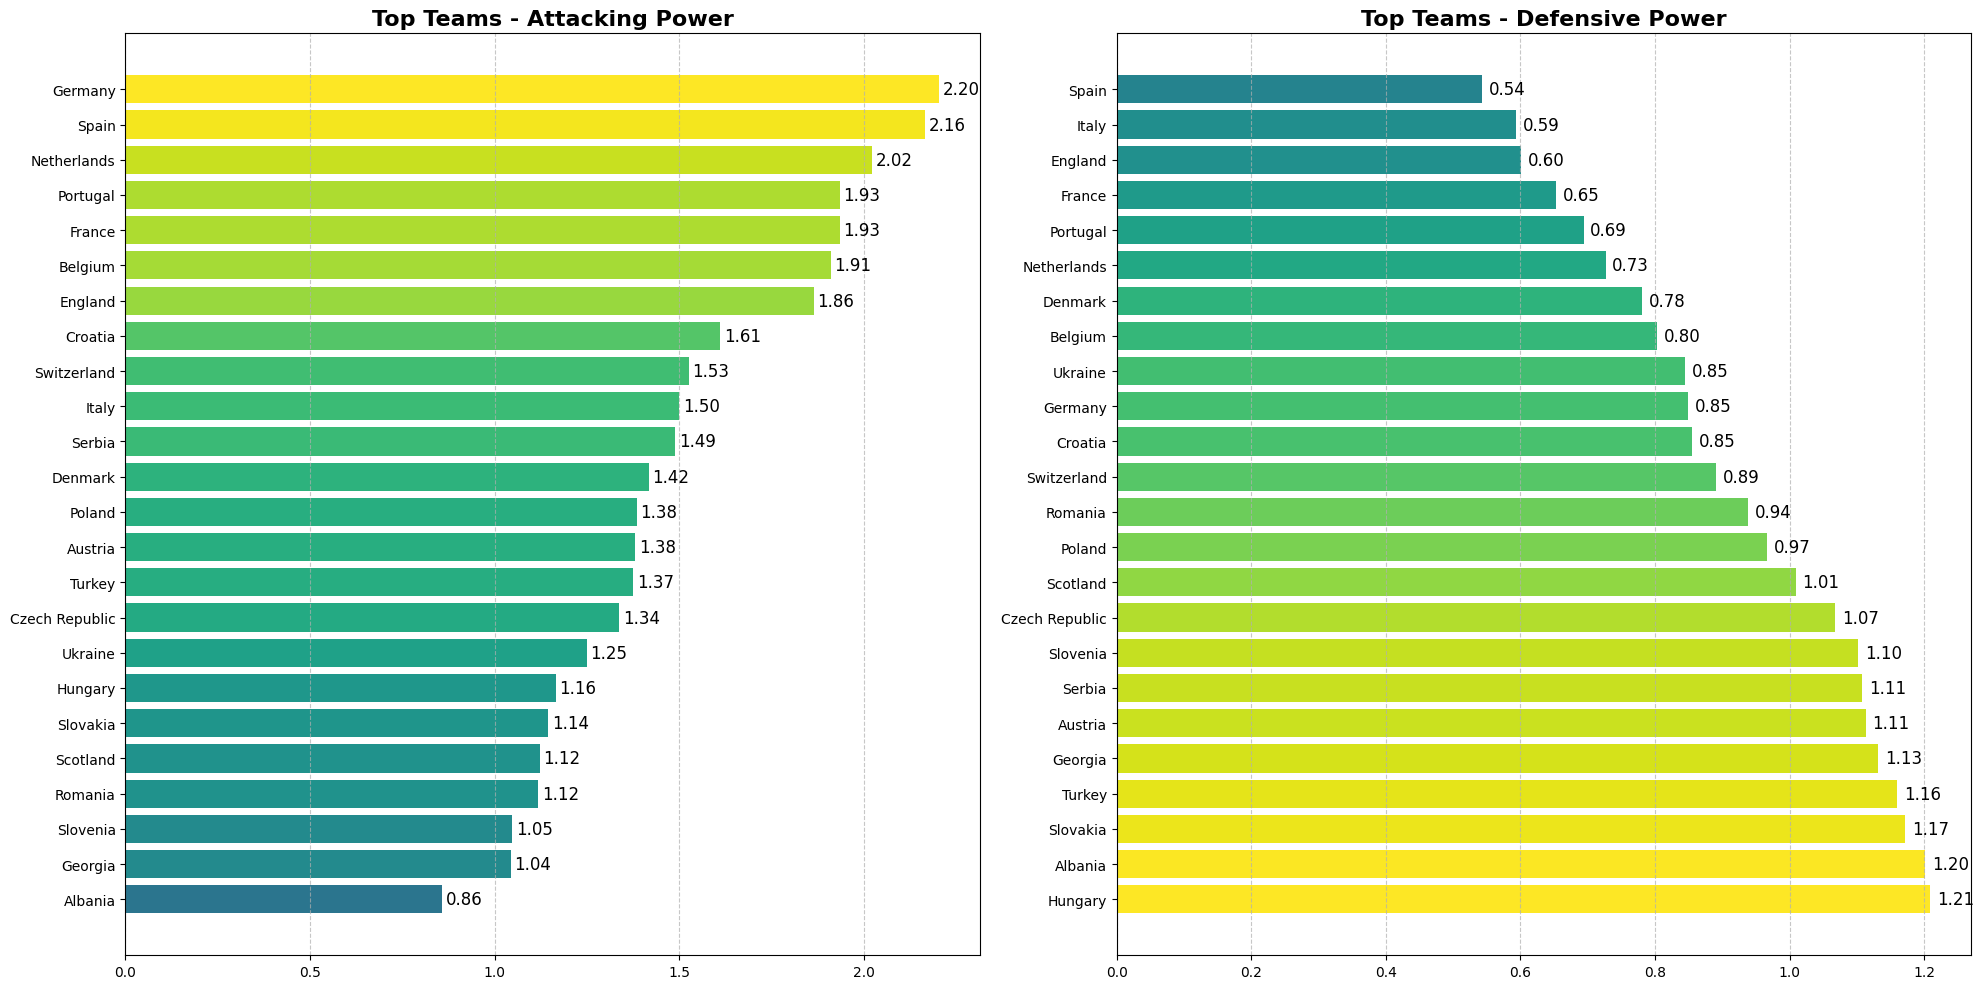

In [24]:
# Plotting top teams by attacking and defensive ratings for Euro 2024 teams
attdef_ranking_europe = attdef[attdef.Team.isin(eurocup_teams)]
plot_top_att_def(attdef_ranking_europe, 24)

# Creating the Reference Dataset and Binning

First, we will create the reference dataset and bin the total expected goals to compare with the actual total scores.

In [27]:
# Filter the dataset to include matches from European tournaments since September 2010
reference_df = data[(data.date > "2010-09-01") & (data.tournament.isin(["UEFA Euro", "UEFA Euro qualification", "UEFA Nations League"]))].copy()

# Calculate the total score and total expected goals for each match
reference_df['total_score'] = reference_df['away_score'] + reference_df['home_score']
reference_df['total_xG'] = reference_df['XGhome'] + reference_df['XGaway']

# Define bins for total expected goals
xG_bins = np.array([1.5, 2.25, 2.5, 2.75, 3, 10])

# Assign each match to a bin based on total expected goals
reference_df['total_xG_bin'] = pd.cut(reference_df['total_xG'], xG_bins)

# Group by the bins and calculate the mean and count of the actual total scores
binned_means = reference_df.groupby('total_xG_bin')['total_score'].agg(["mean", "count"])

print(binned_means)

                  mean  count
total_xG_bin                 
(1.5, 2.25]   2.161765    204
(2.25, 2.5]   2.295139    288
(2.5, 2.75]   2.520202    396
(2.75, 3.0]   2.628986    345
(3.0, 10.0]   3.371765    425


C:\Users\Dusica\AppData\Local\Temp\ipykernel_24124\2292010634.py:15: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  binned_means = reference_df.groupby('total_xG_bin')['total_score'].agg(["mean", "count"])


Next thing is to analyze how well the expected goals align with actual goals by using the Poisson distribution.

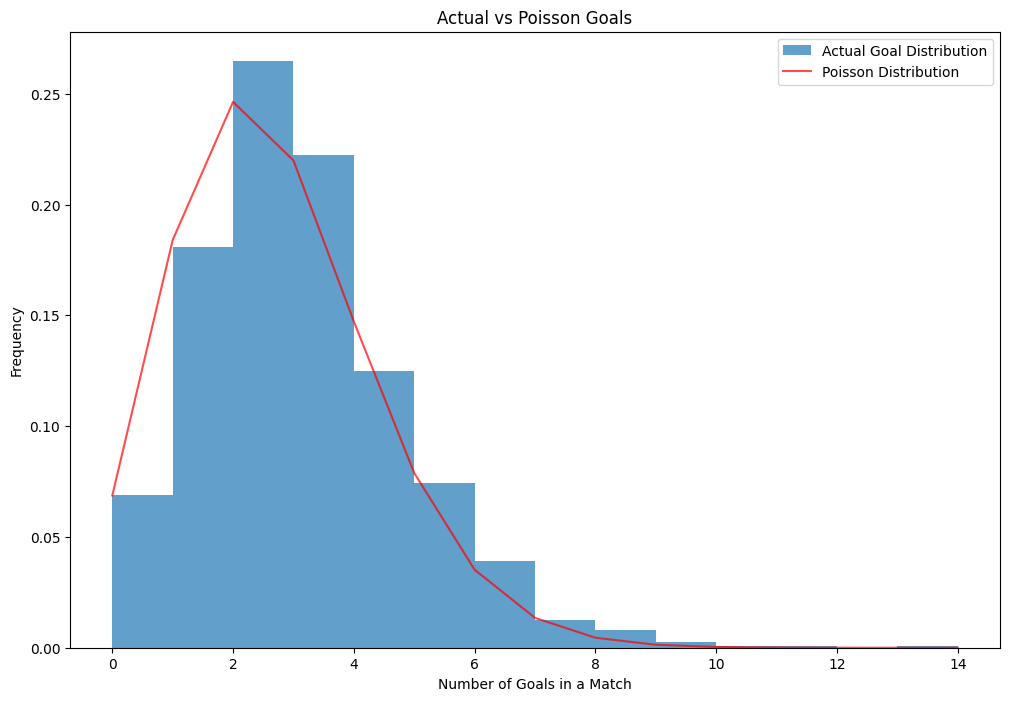

In [29]:
# Calculate the mean of the actual total scores to use as the lambda parameter for the Poisson distribution
lambda_mean = reference_df['total_score'].mean()

# Create a range of possible goal values (0 to max number of goals observed in a match)
goal_range = np.arange(0, reference_df['total_score'].max() + 1)

# Create a Poisson distribution based on the calculated mean
poisson_probabilities = poisson.pmf(goal_range, lambda_mean)

plt.figure(figsize=(12, 8))

# Plot the histogram of actual goal distribution
plt.hist(reference_df['total_score'], bins=goal_range, density=True, alpha=0.7, label='Actual Goal Distribution')

# Plot the Poisson distribution
plt.plot(goal_range, poisson_probabilities, 'r-', alpha=0.7, label='Poisson Distribution')

plt.title('Actual vs Poisson Goals')
plt.xlabel('Number of Goals in a Match')
plt.ylabel('Frequency')
plt.legend()

plt.show()

In [30]:
# Calculate the probabilities of match outcomes using Poisson distribution
def calculate_match_probabilities(lambda_home, lambda_away, max_goals=6):
    # Initialize a matrix to store the probabilities
    probability_matrix = np.zeros((max_goals + 1, max_goals + 1))

    # Calculate probabilities for each possible goal count for both teams
    for home_goals in range(max_goals + 1):
        for away_goals in range(max_goals + 1):
            probability_matrix[home_goals, away_goals] = poisson.pmf(home_goals, lambda_home) * poisson.pmf(away_goals, lambda_away)

    # Calculate probabilities for total goals in the match
    total_goals_probabilities = [np.sum(np.diag(probability_matrix[::-1], k)) for k in range(-(max_goals - 1), max_goals + 1)]

    # Calculate probabilities for specific outcomes
    draw_probability = np.sum(np.diag(probability_matrix))
    away_win_probability = np.sum(np.triu(probability_matrix, 1))
    home_win_probability = np.sum(np.tril(probability_matrix, -1))

    return total_goals_probabilities, draw_probability, away_win_probability, home_win_probability

Now, we can use this function to calculate the probabilities for a specific match.

Match: Denmark vs Serbia - 2024-06-25 00:00:00
Actual score: 0.0 - 0.0
Expected goals (xG): Denmark 1.653905317637566, Serbia 1.2177558407226787
Probability of home win: 47.41%
Probability of away win: 28.14%
Probability of draw: 24.26%


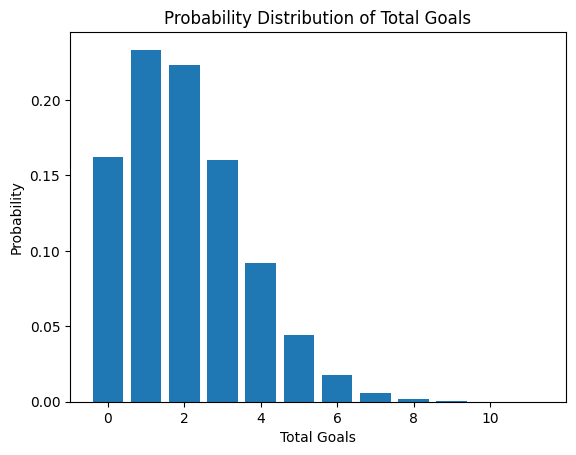

In [36]:
# Convert date column to datetime
data['date'] = pd.to_datetime(data['date'])

# Filter for the match between Denmark and Serbia and find the closest to today's date
home_team_name = 'Denmark'
away_team_name = 'Serbia'
today = pd.to_datetime('today')
matches = data[(data['home_team'] == home_team_name) & (data['away_team'] == away_team_name)]
closest_match = matches.iloc[(matches['date'] - today).abs().argsort()[:1]]

# Extract relevant data
match = closest_match.iloc[0]
home_team = match['home_team']
away_team = match['away_team']
home_goals = match['home_score']
away_goals = match['away_score']
home_xG = match['XGhome']
away_xG = match['XGaway']
date = match['date']

# Calculate match probabilities
goals_probabilities, draw_prob, away_prob, home_prob = calculate_match_probabilities(home_xG, away_xG)

# Display results
print(f"Match: {home_team} vs {away_team} - {date}")
print(f"Actual score: {home_goals} - {away_goals}")
print(f"Expected goals (xG): {home_team} {home_xG}, {away_team} {away_xG}")
print(f"Probability of home win: {round(home_prob * 100, 2)}%")
print(f"Probability of away win: {round(away_prob * 100, 2)}%")
print(f"Probability of draw: {round(draw_prob * 100, 2)}%")

# Plot the distribution of possible total goals
plt.bar(range(len(goals_probabilities)), goals_probabilities)
plt.xlabel('Total Goals')
plt.ylabel('Probability')
plt.title('Probability Distribution of Total Goals')
plt.show()

Finally, we will validate the calculated probabilities against the actual results from the dataset.

In [38]:
# Define the function to calculate probabilities for each match
def apply_calculation(row):
    total_goals_prob, draw_prob, away_prob, home_prob = calculate_match_probabilities(row['XGhome'], row['XGaway'])
    return pd.Series({
        'total_goals_prob': total_goals_prob,
        'draw_prob': draw_prob,
        'away_prob': away_prob,
        'home_prob': home_prob
    })

# Apply the function to each row in the filtered dataset
calculated_variables = reference_df.apply(apply_calculation, axis=1)

# Concatenate the results with the original DataFrame
df_euro = pd.concat([reference_df, calculated_variables], axis=1)

# Iterate over each row to create new columns for probabilities of specific total goals
for index, row in df_euro.iterrows():
    for i, prob in enumerate(row['total_goals_prob']):
        df_euro.at[index, f'prob_index_goals_{i}'] = prob

# Compute the actual outcome based on the home and away scores
df_euro['result'] = np.where(df_euro['home_score'] > df_euro['away_score'], 'home_win',
                             np.where(df_euro['home_score'] == df_euro['away_score'], 'draw', 'away_win'))

df_euro['home_win_flag'] = np.where(df_euro['result'] == 'home_win', 1, 0)
df_euro['draw_flag'] = np.where(df_euro['result'] == 'draw', 1, 0)
df_euro['away_win_flag'] = np.where(df_euro['result'] == 'away_win', 1, 0)

# Define bins for grouping based on predicted probabilities
bins = [0, 0.2, 0.4, 0.6, 0.8, 1]

# Create a new column indicating the bin for each match based on predicted probabilities
df_euro['probability_bin'] = pd.cut(df_euro['home_prob'], bins=bins)

# Group the DataFrame by the probability bins and compute the percentage of actual outcomes within each group
result_distribution = df_euro.groupby('probability_bin')['result'].value_counts(normalize=True).unstack() * 100


C:\Users\Dusica\AppData\Local\Temp\ipykernel_24124\194968641.py:37: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  result_distribution = df_euro.groupby('probability_bin')['result'].value_counts(normalize=True).unstack() * 100


<Figure size 1200x600 with 0 Axes>

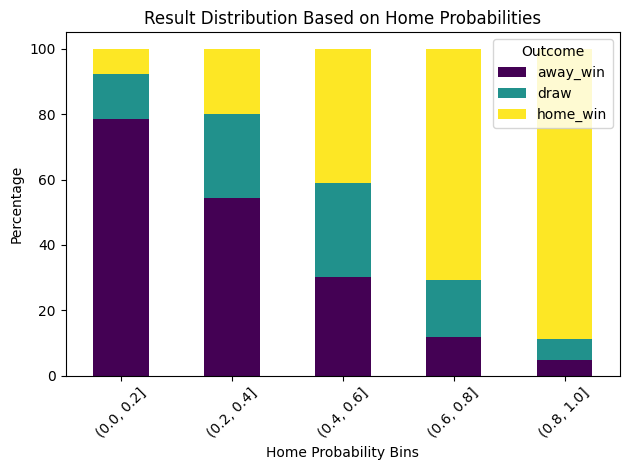

In [39]:
# Plotting the result distribution based on home probabilities
plt.figure(figsize=(12, 6))
result_distribution.plot(kind='bar', stacked=True, cmap='viridis')
plt.title('Result Distribution Based on Home Probabilities')
plt.xlabel('Home Probability Bins')
plt.ylabel('Percentage')
plt.xticks(rotation=45)
plt.legend(title='Outcome')
plt.tight_layout()

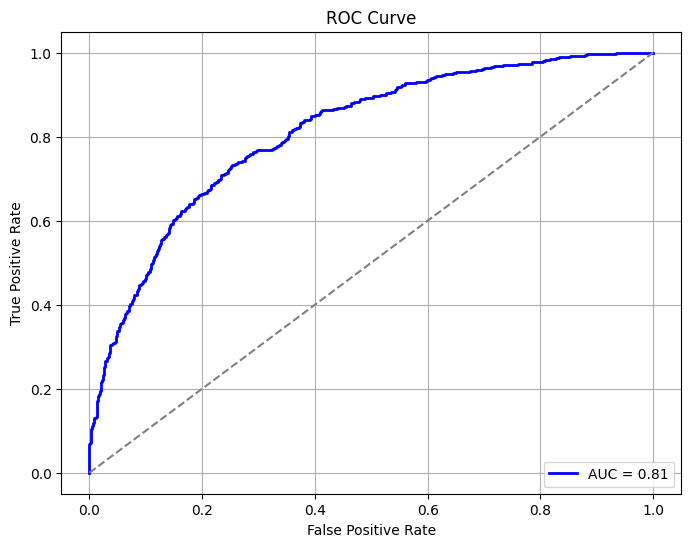

In [43]:
# ROC Curve for Home Win Prediction
fpr, tpr, thresholds = roc_curve(df_euro['home_win_flag'], df_euro['home_prob'])
auc = roc_auc_score(df_euro['home_win_flag'], df_euro['home_prob'])

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'AUC = {auc:.2f}')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

In [42]:
print(f"AUC: {auc:.2f}")

AUC: 0.81


In [41]:
# Validate away win probabilities
df_euro['probability_bin'] = pd.cut(df_euro['away_prob'], bins=[0, 0.15, 0.3, 0.6, 1])
result_distribution = df_euro.groupby('probability_bin')['result'].value_counts(normalize=True).unstack() * 100
print(result_distribution)

# Compute AUC for away win
auc_away = roc_auc_score(df_euro['away_win_flag'], df_euro['away_prob'])
print(f"AUC: {auc_away:.2f}")

result            away_win       draw   home_win
probability_bin                                 
(0.0, 0.15]       9.386973  13.409962  77.203065
(0.15, 0.3]      25.053079  27.388535  47.558386
(0.3, 0.6]       53.191489  26.499033  20.309478
(0.6, 1.0]       86.486486   8.783784   4.729730
AUC: 0.81


C:\Users\Dusica\AppData\Local\Temp\ipykernel_24124\1446040402.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  result_distribution = df_euro.groupby('probability_bin')['result'].value_counts(normalize=True).unstack() * 100


# Euro 2024 Winner Prediction

In [44]:
# Define the EURO match data
matches_data = [
    # Group A
    {"Group": "A", "Home_Team": "Germany", "Away_Team": "Scotland"},
    {"Group": "A", "Home_Team": "Hungary", "Away_Team": "Switzerland"},
    {"Group": "A", "Home_Team": "Germany", "Away_Team": "Hungary"},
    {"Group": "A", "Home_Team": "Scotland", "Away_Team": "Switzerland"},
    {"Group": "A", "Home_Team": "Switzerland", "Away_Team": "Germany"},
    {"Group": "A", "Home_Team": "Scotland", "Away_Team": "Hungary"},
    # Group B
    {"Group": "B", "Home_Team": "Spain", "Away_Team": "Croatia"},
    {"Group": "B", "Home_Team": "Italy", "Away_Team": "Albania"},
    {"Group": "B", "Home_Team": "Croatia", "Away_Team": "Albania"},
    {"Group": "B", "Home_Team": "Spain", "Away_Team": "Italy"},
    {"Group": "B", "Home_Team": "Albania", "Away_Team": "Spain"},
    {"Group": "B", "Home_Team": "Croatia", "Away_Team": "Italy"},
    # Group C
    {"Group": "C", "Home_Team": "Slovenia", "Away_Team": "Denmark"},
    {"Group": "C", "Home_Team": "Serbia", "Away_Team": "England"},
    {"Group": "C", "Home_Team": "Slovenia", "Away_Team": "Serbia"},
    {"Group": "C", "Home_Team": "Denmark", "Away_Team": "England"},
    {"Group": "C", "Home_Team": "England", "Away_Team": "Slovenia"},
    {"Group": "C", "Home_Team": "Denmark", "Away_Team": "Serbia"},
    # Group D
    {"Group": "D", "Home_Team": "Poland", "Away_Team": "Netherlands"},
    {"Group": "D", "Home_Team": "Austria", "Away_Team": "France"},
    {"Group": "D", "Home_Team": "Poland", "Away_Team": "Austria"},
    {"Group": "D", "Home_Team": "Netherlands", "Away_Team": "France"},
    {"Group": "D", "Home_Team": "Netherlands", "Away_Team": "Austria"},
    {"Group": "D", "Home_Team": "France", "Away_Team": "Poland"},
    # Group E
    {"Group": "E", "Home_Team": "Romania", "Away_Team": "Ukraine"},
    {"Group": "E", "Home_Team": "Belgium", "Away_Team": "Slovakia"},
    {"Group": "E", "Home_Team": "Slovakia", "Away_Team": "Ukraine"},
    {"Group": "E", "Home_Team": "Belgium", "Away_Team": "Romania"},
    {"Group": "E", "Home_Team": "Slovakia", "Away_Team": "Romania"},
    {"Group": "E", "Home_Team": "Ukraine", "Away_Team": "Belgium"},
    # Group F
    {"Group": "F", "Home_Team": "Turkey", "Away_Team": "Georgia"},
    {"Group": "F", "Home_Team": "Portugal", "Away_Team": "Czech Republic"},
    {"Group": "F", "Home_Team": "Georgia", "Away_Team": "Czech Republic"},
    {"Group": "F", "Home_Team": "Turkey", "Away_Team": "Portugal"},
    {"Group": "F", "Home_Team": "Georgia", "Away_Team": "Portugal"},
    {"Group": "F", "Home_Team": "Czech Republic", "Away_Team": "Turkey"},
]

In [45]:
# Create a dataframe for the matches
matches_df = pd.DataFrame(matches_data)

# Merge the dataframes based on the "Home Team" and "Away Team" columns and rename columns with prefix
merged_df = pd.merge(matches_df, attdef[["Team", "att", "def"]].add_prefix('Home_'), left_on="Home_Team", right_on="Home_Team", how="left")
group_matches = pd.merge(merged_df, attdef[["Team", "att", "def"]].add_prefix('Away_'), left_on="Away_Team", right_on="Away_Team", how="left")

In [46]:
# Compute the expected goals
group_matches['XGhome'] = group_matches['Home_att'] * group_matches['Away_def']
group_matches['XGaway'] = group_matches['Home_def'] * group_matches['Away_att']

# Apply the calculate_match_probabilities function to each row
group_matches[['total_goals_prob', 'draw_prob', 'away_prob', 'home_prob']] = group_matches[['XGhome','XGaway']].apply(lambda row: pd.Series(calculate_match_probabilities(row['XGhome'], row['XGaway'])), axis=1)

# Drop the total_goals_prob column
group_matches.drop("total_goals_prob", axis=1, inplace=True)

In [48]:
# Define a function to determine the result based on probabilities
def determine_result_random(row):
    random_number = np.random.random()
    if random_number < row["draw_prob"]:
        return "Draw"
    elif random_number < row["draw_prob"] + row["away_prob"]:
        return row["Away_Team"]
    else:
        return row["Home_Team"]

def determine_result(row):
    max_prob = max(row["draw_prob"], row["away_prob"], row["home_prob"])
    if row["draw_prob"] == max_prob:
        return "Draw"
    elif row["away_prob"] == max_prob:
        return row["Away_Team"]
    else:
        return row["Home_Team"]

def determine_result_knockout(row):
    if row["away_prob"] > row["home_prob"]:
        return row["Away_Team"]
    else:
        return row["Home_Team"]

def determine_result_knockout_random(row):
    random_number = np.random.random()
    if random_number < row["draw_prob"]:
        random_number2 = np.random.random()
        if random_number < 0.5:
            return row["Away_Team"]
        else:
            return row["Home_Team"]
    elif random_number < row["draw_prob"] + row["away_prob"]:
        return row["Away_Team"]
    else:
        return row["Home_Team"]
    
# Apply the function to create the "Results" column
group_matches["Result"] = group_matches.apply(determine_result, axis=1)

In [49]:
# Display the predictions for each group
for group in group_matches["Group"].unique():
    print(f"Group {group} predictions:")
    print(group_matches[group_matches.Group == group][["Home_Team","Away_Team", "home_prob","draw_prob","away_prob","XGhome","XGaway","Result"]])
    print()

Group A predictions:
     Home_Team    Away_Team  home_prob  draw_prob  away_prob    XGhome  \
0      Germany     Scotland   0.653462   0.189761   0.148860  2.222160   
1      Hungary  Switzerland   0.210333   0.226869   0.559763  1.036831   
2      Germany      Hungary   0.709769   0.154851   0.116052  2.662692   
3     Scotland  Switzerland   0.245692   0.256014   0.497139  0.999122   
4  Switzerland      Germany   0.251325   0.219165   0.525030  1.296001   
5     Scotland      Hungary   0.409117   0.266745   0.323400  1.356463   

     XGaway       Result  
0  0.953315      Germany  
1  1.844067  Switzerland  
2  0.989295      Germany  
3  1.538974  Switzerland  
4  1.961243      Germany  
5  1.174767     Scotland  

Group B predictions:
   Home_Team Away_Team  home_prob  draw_prob  away_prob    XGhome    XGaway  \
6      Spain   Croatia   0.600854   0.223132   0.172996  1.849868  0.873993   
7      Italy   Albania   0.686562   0.213154   0.097694  1.802366  0.508687   
8    Croatia

In [50]:
# Define a function to calculate points based on match results
def calculate_points(result, home_team, away_team):
    if result == "Draw":
        return 1, 1
    elif result == home_team:
        return 3, 0
    elif result == away_team:
        return 0, 3

Script predicts the outcomes of the 2024 Euro matches using the calculated probabilities and simulates multiple iterations to estimate the likelihood of different teams advancing from the group stage. It also calculates the expected points and ranks for each team in their respective groups.

In [113]:
# Define your functions determine_result_random and calculate_points here

num_simulations = 10000  # Number of simulations
standings_list = []  # List to store standings for each simulation

for _ in range(num_simulations):
    group_matches["Result"] = group_matches.apply(determine_result_random, axis=1)
    group_matches[["Points_Home", "Points_Away"]] = group_matches.apply(lambda row: pd.Series(calculate_points(row["Result"], row["Home_Team"], row["Away_Team"])), axis=1)
    # Create a dataframe to store points for each team
    standings = pd.DataFrame(columns=["Group","Team", "Points"])
    # Concatenate Home and Away points by group
    for group_name, group_data in group_matches.groupby("Group"):
        group_points_df = pd.DataFrame(columns=["Team", "Points"])
        for team in set(group_data["Home_Team"]).union(set(group_data["Away_Team"])):
            home_points = group_data.loc[group_data["Home_Team"] == team, "Points_Home"].sum()
            away_points = group_data.loc[group_data["Away_Team"] == team, "Points_Away"].sum()
            total_points = home_points + away_points
            group_points_df = group_points_df._append({"Team": team, "Points": total_points}, ignore_index=True)
        group_points_df = group_points_df.sort_values(by=["Points"], ascending=False).reset_index(drop=True)
        group_points_df["Group"] = group_name
        group_points_df["Rank"] = range(1, len(group_points_df) + 1)
        group_points_df["Qualified_1"] = np.where(group_points_df["Rank"] == 1, 1, 0)
        group_points_df["Qualified_2"] = np.where(group_points_df["Rank"] == 2, 1, 0)
        group_points_df["Qualified_3"] = np.where(group_points_df["Rank"] == 3, 1, 0)
        group_points_df["Qualified_4"] = np.where(group_points_df["Rank"] == 4, 1, 0)
        standings = pd.concat([standings, group_points_df], ignore_index=True)
    standings_list.append(standings)

standings = pd.concat(standings_list).groupby(["Team", "Group"])[["Qualified_1", "Qualified_2", "Qualified_3", "Qualified_4"]].mean().reset_index().sort_values(by=["Group","Qualified_1"], ascending=[True,False])

In [147]:
# Calculate the total points for each team
team_points = group_matches.groupby('Home_Team')['Points_Home'].sum().add(
    group_matches.groupby('Away_Team')['Points_Away'].sum(), fill_value=0)

# Create a DataFrame from the team_points Series
team_points_df = team_points.reset_index()
team_points_df.columns = ['Team', 'Points']

# Merge the points back with the standings DataFrame
standings_with_points = pd.merge(standings, team_points_df, on='Team', how='left')

# Create a dictionary to store standings with points
group_standings_dict = {}

# Populate the dictionary with the standings and points
for group in standings_with_points['Group'].unique():
    group_standings = standings_with_points[standings_with_points['Group'] == group].sort_values(by='Points', ascending=False).reset_index(drop=True)
    group_standings_dict[group] = list(zip(group_standings['Team'], group_standings['Points']))

# Print the group standings dictionary with points
for group, teams in group_standings_dict.items():
    print(f"Group {group}: {teams}")

Group A: [('Germany', 7), ('Hungary', 5), ('Scotland', 4), ('Switzerland', 0)]
Group B: [('Italy', 7), ('Spain', 6), ('Croatia', 4), ('Albania', 0)]
Group C: [('England', 7), ('Denmark', 4), ('Serbia', 3), ('Slovenia', 3)]
Group D: [('France', 7), ('Netherlands', 7), ('Poland', 1), ('Austria', 1)]
Group E: [('Belgium', 7), ('Romania', 5), ('Slovakia', 2), ('Ukraine', 1)]
Group F: [('Turkey', 9), ('Georgia', 4), ('Czech Republic', 3), ('Portugal', 1)]


# Set Up Knockout Stage 

Based on the group standings we have already calculated, we will set up the matches for the Round of 16.
We need to simulate the knockout stages using the same methodology as the group stages.

In [145]:
# Function to simulate knockout matches
def simulate_knockout_match(team1, team2, group_matches):
    team1_xG = group_matches[group_matches['Home_Team'] == team1]['XGhome'].mean() + group_matches[group_matches['Away_Team'] == team2]['XGaway'].mean()
    team2_xG = group_matches[group_matches['Away_Team'] == team1]['XGaway'].mean() + group_matches[group_matches['Home_Team'] == team2]['XGhome'].mean()
    team1_score = np.random.poisson(team1_xG)
    team2_score = np.random.poisson(team2_xG)
    if team1_score > team2_score:
        return team1
    elif team2_score > team1_score:
        return team2
    else:  # Penalty shootout
        return np.random.choice([team1, team2])

In [149]:
# Function to get top 4 third-placed teams
def get_top_4_third_placed_teams(group_standings_dict_with_points):
    third_placed_teams = []
    for group, teams in group_standings_dict_with_points.items():
        if len(teams) >= 3:
            third_placed_teams.append(teams[2])
    
    # Sort third-placed teams by points
    third_placed_teams_sorted = sorted(third_placed_teams, key=lambda x: x[1], reverse=True)
    
    # If there is a tie for the 4th place, resolve it based on the standings
    if len(third_placed_teams_sorted) > 4 and third_placed_teams_sorted[3][1] == third_placed_teams_sorted[4][1]:
        tied_teams = [team for team in third_placed_teams_sorted if team[1] == third_placed_teams_sorted[3][1]]
        tied_teams_sorted = sorted(tied_teams, key=lambda x: (standings_with_points[standings_with_points['Team'] == x[0]]['Qualified_1'].values[0], 
                                                              standings_with_points[standings_with_points['Team'] == x[0]]['Qualified_2'].values[0], 
                                                              standings_with_points[standings_with_points['Team'] == x[0]]['Qualified_3'].values[0], 
                                                              standings_with_points[standings_with_points['Team'] == x[0]]['Qualified_4'].values[0]), 
                                  reverse=True)
        top_4_teams = third_placed_teams_sorted[:3] + tied_teams_sorted[:1]
    else:
        top_4_teams = third_placed_teams_sorted[:4]

    return top_4_teams

# Get the top 4 third-placed teams
top_4_third_placed_teams = get_top_4_third_placed_teams(group_standings_dict)

print("\nTop 4 Third-Placed Teams:")
print("-------------------------")
for team, points in top_4_third_placed_teams:
    print(f"{team} - Points: {points}")


Top 4 Third-Placed Teams:
-------------------------
Scotland - Points: 4
Croatia - Points: 4
Serbia - Points: 3
Czech Republic - Points: 3


In [150]:
# Round of 16 matchups based on group results
round_of_16_matchups = [
    (group_standings_dict["A"][0][0], group_standings_dict["C"][1][0]), 
    (group_standings_dict["B"][0][0], group_standings_dict["A"][2][0]), 
    (group_standings_dict["F"][0][0], group_standings_dict["C"][2][0]), 
    (group_standings_dict["D"][1][0], group_standings_dict["E"][1][0]), 
    (group_standings_dict["A"][1][0], group_standings_dict["B"][1][0]), 
    (group_standings_dict["C"][0][0], group_standings_dict["F"][2][0]), 
    (group_standings_dict["E"][0][0], group_standings_dict["B"][2][0]), 
    (group_standings_dict["D"][0][0], group_standings_dict["F"][1][0])
]

# Simulate Round of 16
round_of_16_results = []
for team1, team2 in round_of_16_matchups:
    winner = simulate_knockout_match(team1, team2, group_matches)
    round_of_16_results.append((team1, team2, winner))

# Print Round of 16 results
print("\nRound of 16 Results:")
print("--------------------")
for team1, team2, winner in round_of_16_results:
    print(f"{team1} vs {team2} -> Winner: {winner}")

ValueError: lam < 0 or lam is NaN

# Calculate Further Rounds

Continue the simulation for the quarter-finals, semi-finals, and the final based on the winners from each round.

In [99]:
# Quarterfinal matchups based on Round of 16 results
quarterfinal_matchups = [
    (round_of_16_results[0][2], round_of_16_results[1][2]),
    (round_of_16_results[2][2], round_of_16_results[3][2]),
    (round_of_16_results[4][2], round_of_16_results[5][2]),
    (round_of_16_results[6][2], round_of_16_results[7][2])
]

# Simulate Quarterfinals
quarterfinal_results = []
for team1, team2 in quarterfinal_matchups:
    winner = simulate_knockout_match(team1, team2, group_matches)
    quarterfinal_results.append((team1, team2, winner))

# Print Quarterfinal results
print("\nQuarterfinal Results:")
print("--------------------")
for team1, team2, winner in quarterfinal_results:
    print(f"{team1} vs {team2} -> Winner: {winner}")


Quarterfinal Results:
Germany vs Italy -> Winner: Italy
Czech Republic vs England -> Winner: England
France vs Belgium -> Winner: France
Portugal vs Ukraine -> Winner: Portugal


In [104]:
# Semifinal matchups based on Quarterfinal results
semifinal_matchups = [
    (quarterfinal_results[0][2], quarterfinal_results[1][2]),
    (quarterfinal_results[2][2], quarterfinal_results[3][2])
]

# Simulate Semifinals
semifinal_results = []
for team1, team2 in semifinal_matchups:
    winner = simulate_knockout_match(team1, team2, group_matches)
    semifinal_results.append((team1, team2, winner))

# Print Semifinal results
print("\nSemifinal Results:")
print("--------------------")
for team1, team2, winner in semifinal_results:
    print(f"{team1} vs {team2} -> Winner: {winner}")


Semifinal Results:
Italy vs England -> Winner: England
France vs Portugal -> Winner: France


In [107]:
# Final matchup based on Semifinal results
final_matchup = (semifinal_results[0][2], semifinal_results[1][2])

# Simulate Final
final_winner = simulate_knockout_match(final_matchup[0], final_matchup[1], group_matches)

# Print Final result
print("\nFinal Result:")
print("--------------------")
print(f"{final_matchup[0]} vs {final_matchup[1]} -> Winner: {final_winner}")


Final Result:
England vs France -> Winner: France
